# Claims frequency modeling with XGBoost (Poisson & Tweedie)

This notebook:
- Loads the prepared freMTPL2freq dataset (`claims_prepared.csv`).
- Builds a preprocessing pipeline (numeric passthrough + one-hot for categoricals).
- Fits tuned Poisson and Tweedie XGBoost models with fixed hyperparameters.
- Evaluates models with custom metrics tailored to zero-inflated claim counts:
  - Poisson deviance,
  - RMSE on counts,
  - exact match rate after rounding,
  - zero share (true vs predicted),
  - non-zero recall & precision,
  - KL divergence on 0/1/2/3+ buckets.
- Runs feature ablation experiments.
- Trains a final Poisson model **without `Area`** and evaluates it.

Hyperparameter search (RandomizedSearchCV) is documented at the end
in a separate markdown cell, but not re-run in this production version.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_poisson_deviance, root_mean_squared_error

from xgboost import XGBRegressor

sns.set(style="whitegrid")

# Paths and column configuration
DATA_PATH = "../data/claims_prepared.csv"

TARGET_COL = "ClaimNb"
EXPOSURE_COL = "Exposure"
ID_COL = "IDpol"

# Base feature set - based on pre-cleaning conclusions
XGB_FEATURE_COLS = [
    "Area",
    "VehBrand_lumped",
    "VehGas",
    "Region_lumped",
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "logDensity",
]

# Tuned XGBoost hyperparameters (frozen for production)

These come from several RandomizedSearchCV stages
(full code is documented at the end of the notebook).

Below we only **freeze** the final best configurations.

In [2]:
# Best Poisson XGB params (ultra-tuned):
# Best params (ultra):
# {'model__subsample': 0.95, 'model__reg_lambda': 0.5, 'model__reg_alpha': 1.0,
#  'model__n_estimators': 600, 'model__min_child_weight': 2, 'model__max_depth': 9,
#  'model__learning_rate': 0.05, 'model__gamma': 0.3, 'model__colsample_bytree': 0.65}
# Best CV Poisson deviance (ultra): ~ -0.30376
POISSON_XGB_PARAMS = dict(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
    n_estimators=600,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.95,
    colsample_bytree=0.65,
    min_child_weight=2,
    gamma=0.3,
    reg_lambda=0.5,
    reg_alpha=1.0,
    n_jobs=-1,
    verbosity=0,
)

# Best Tweedie-XGB params:
# {'model__tweedie_variance_power': 1.3, 'model__subsample': 0.8,
#  'model__reg_lambda': 10.0, 'model__reg_alpha': 0.0,
#  'model__n_estimators': 500, 'model__min_child_weight': 3, 'model__max_depth': 6,
#  'model__learning_rate': 0.05, 'model__gamma': 0.0, 'model__colsample_bytree': 0.7}
# Best Tweedie-XGB CV Poisson dev: ~ -0.30395
TWEEDIE_XGB_PARAMS = dict(
    objective="reg:tweedie",
    tweedie_variance_power=1.3,
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=0.0,
    reg_lambda=10.0,
    reg_alpha=0.0,
    n_jobs=-1,
    verbosity=0,
)

# Utility functions: metrics, plots, importance aggregation

In [3]:
def evaluate_count_model(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    label: str = "model",
    max_bin: int = 3,
):
    """
    Evaluate a count model on claim counts with several interpretable metrics.

    Metrics
    -------
    - Poisson deviance (lower is better).
    - RMSE on claim counts.
    - Exact match rate after rounding predictions to the nearest integer.
    - Zero share (observed vs predicted).
    - Non-zero recall: P(pred >= 1 | y_true >= 1).
    - Non-zero precision: P(y_true >= 1 | pred >= 1).
    - KL divergence between observed and predicted 0/1/2/3+ distributions.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Observed claim counts.
    y_pred : array-like of shape (n_samples,)
        Predicted claim counts (continuous).
    label : str, optional
        Model label used only for printing.
    max_bin : int, optional
        Highest bucket for the KL divergence (values above are capped).

    Returns
    -------
    metrics : dict
        Dictionary containing all metrics.
    y_pred_round : np.ndarray of shape (n_samples,)
        Integer-rounded predictions.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # Ensure strictly positive predictions for Poisson deviance
    y_pred_safe = np.clip(y_pred, 1e-9, None)

    # Core numeric metrics
    pois_dev = mean_poisson_deviance(y_true, y_pred_safe)
    rmse = root_mean_squared_error(y_true, y_pred_safe)

    # Rounded predictions
    y_pred_round = np.rint(y_pred_safe).astype(int)
    exact_match = np.mean(y_true == y_pred_round)

    # Zero share
    is_zero_true = (y_true == 0)
    is_zero_pred = (y_pred_round == 0)
    zero_share_true = is_zero_true.mean()
    zero_share_pred = is_zero_pred.mean()

    # Non-zero recall & precision: treat "has >=1 claim" as positive
    has_claim_true = (y_true >= 1)
    has_claim_pred = (y_pred_round >= 1)

    n_true_pos = has_claim_true.sum()
    n_pred_pos = has_claim_pred.sum()
    n_tp = np.logical_and(has_claim_true, has_claim_pred).sum()

    nonzero_recall = n_tp / n_true_pos if n_true_pos > 0 else np.nan
    nonzero_precision = n_tp / n_pred_pos if n_pred_pos > 0 else np.nan

    # KL divergence on 0 / 1 / 2 / 3+ distribution
    y_true_bins = np.clip(y_true.astype(int), 0, max_bin)
    y_pred_bins = np.clip(y_pred_round, 0, max_bin)

    true_counts = np.bincount(y_true_bins, minlength=max_bin + 1).astype(float)
    pred_counts = np.bincount(y_pred_bins, minlength=max_bin + 1).astype(float)

    true_probs = true_counts / true_counts.sum()
    pred_probs = pred_counts / pred_counts.sum()

    eps = 1e-8
    kl_div = np.sum(true_probs * np.log((true_probs + eps) / (pred_probs + eps)))

    metrics = {
        "poisson_deviance": pois_dev,
        "rmse": rmse,
        "exact_match_rounded": exact_match,
        "zero_share_true": zero_share_true,
        "zero_share_pred": zero_share_pred,
        "nonzero_recall": nonzero_recall,
        "nonzero_precision": nonzero_precision,
        "kl_divergence_0_1_2_3plus": kl_div,
    }

    print(f"\n=== {label} ===")
    print(f"Poisson deviance            : {pois_dev:.4f}")
    print(f"RMSE (claims)               : {rmse:.4f}")
    print(f"Exact match (rounded)       : {exact_match:.3f}")
    print(f"Zero share (true)           : {zero_share_true:.3f}")
    print(f"Zero share (pred)           : {zero_share_pred:.3f}")
    print(f"Non-zero recall             : {nonzero_recall:.3f}")
    print(f"Non-zero precision          : {nonzero_precision:.3f}")
    print(f"KL divergence (0/1/2/3+)    : {kl_div:.4f}")

    return metrics, y_pred_round


def plot_observed_vs_predicted_counts(
    y_true: np.ndarray,
    y_pred_round: np.ndarray,
    max_count: int = 5,
    title_prefix: str = "",
) -> None:
    """
    Plot observed vs predicted (rounded) claim count distributions.

    Produces two plots:
    - Zero-claim policies: observed vs predicted.
    - Non-zero policies: 1..max_count+ bins.
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred_round = np.asarray(y_pred_round, dtype=int)

    y_true_clip = np.clip(y_true, 0, max_count)
    y_pred_clip = np.clip(y_pred_round, 0, max_count)

    true_counts = np.bincount(y_true_clip, minlength=max_count + 1)
    pred_counts = np.bincount(y_pred_clip, minlength=max_count + 1)

    labels = [str(k) for k in range(max_count)]
    labels.append(f"{max_count}+")

    df_plot = pd.DataFrame(
        {
            "count_bin": labels,
            "observed_policies": true_counts,
            "predicted_policies": pred_counts,
        }
    )

    df_melt = df_plot.melt(
        id_vars="count_bin",
        value_vars=["observed_policies", "predicted_policies"],
        var_name="type",
        value_name="policies",
    )

    # Zero-claim plot
    df_zero = df_melt[df_melt["count_bin"] == "0"]

    plt.figure(figsize=(5, 4))
    sns.barplot(data=df_zero, x="type", y="policies")
    plt.xlabel("")
    plt.ylabel("Number of policies")
    plt.title(f"{title_prefix}Zero-claim policies: observed vs predicted")
    plt.xticks([0, 1], ["Observed", "Predicted"])
    plt.tight_layout()
    plt.show()

    # 1+ claims plot
    df_nonzero = df_melt[df_melt["count_bin"] != "0"]

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_nonzero, x="count_bin", y="policies", hue="type")
    plt.xlabel("Number of claims in period")
    plt.ylabel("Number of policies")
    plt.title(f"{title_prefix}Observed vs predicted (1+ claims)")
    plt.tight_layout()
    plt.show()


def build_positive_count_table(
    y_true: np.ndarray,
    y_pred_round: np.ndarray,
    max_count: int = 15,
) -> pd.DataFrame:
    """
    Build a table with observed vs predicted policy counts
    for strictly positive claim numbers (1..max_count).
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred_round = np.asarray(y_pred_round, dtype=int)

    rows = []
    for k in range(1, max_count + 1):
        rows.append(
            {
                "n_claims": k,
                "observed_policies": int((y_true == k).sum()),
                "predicted_policies": int((y_pred_round == k).sum()),
            }
        )
    return pd.DataFrame(rows)


def aggregate_importance_by_source(
    fi_df: pd.DataFrame,
    cat_cols: list,
) -> pd.DataFrame:
    """
    Aggregate tree importance from one-hot encoded columns
    back to original feature names.

    Numeric features keep their own name.
    For categorical features, all dummies with the same prefix are summed.
    """
    base_features = []

    for feat in fi_df["feature"]:
        base = feat  # assume numeric by default
        for c in cat_cols:
            prefix = c + "_"
            if feat.startswith(prefix):
                base = c
                break
        base_features.append(base)

    tmp = fi_df.copy()
    tmp["base_feature"] = base_features

    agg = (
        tmp.groupby("base_feature")["importance"]
        .sum()
        .sort_values(ascending=False)
        .reset_index()
    )
    return agg

# Data loading, train/test split, preprocessing

In [4]:
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

# Target, exposure and features
y = df[TARGET_COL]
exposure = df[EXPOSURE_COL]
X = df[XGB_FEATURE_COLS]

# Train/test split (exposure carried along for sample_weight)
X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X,
    y,
    exposure,
    test_size=0.2,
    random_state=42,
)

print("\nTrain / test shapes:", X_train.shape, X_test.shape)

# Identify categorical and numeric features for preprocessing
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("\nCategorical features:", cat_features)
print("Numeric features    :", num_features)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

(678013, 16)

Train / test shapes: (542410, 9) (135603, 9)

Categorical features: ['Area', 'VehBrand_lumped', 'VehGas', 'Region_lumped']
Numeric features    : ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'logDensity']


# Flat actuarial baseline (global mean ClaimNb)

In [5]:
global_mean_claim = y_train.mean()
print("Global mean ClaimNb (train):", global_mean_claim)

y_pred_baseline = np.full_like(y_test, fill_value=global_mean_claim, dtype=float)

baseline_pois_dev = mean_poisson_deviance(y_test, y_pred_baseline)
baseline_rmse = root_mean_squared_error(y_test, y_pred_baseline)

print("\n=== Flat baseline (global mean) ===")
print(f"Poisson deviance: {baseline_pois_dev:.4f}")
print(f"RMSE: {baseline_rmse:.4f}")

Global mean ClaimNb (train): 0.05320882727088365

=== Flat baseline (global mean) ===
Poisson deviance: 0.3212
RMSE: 0.2383


# Tuned Poisson XGBoost model


=== Poisson XGB (tuned, full features) ===
Poisson deviance            : 0.3057
RMSE (claims)               : 0.2360
Exact match (rounded)       : 0.949
Zero share (true)           : 0.950
Zero share (pred)           : 0.999
Non-zero recall             : 0.006
Non-zero precision          : 0.365
KL divergence (0/1/2/3+)    : 0.1827


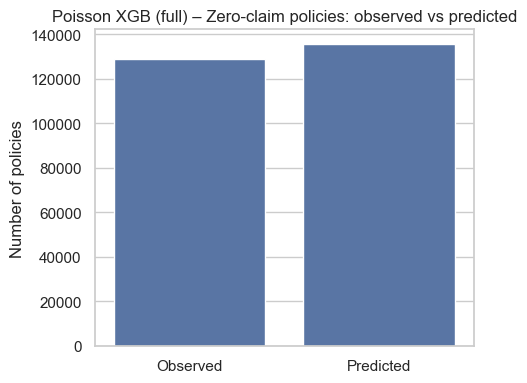

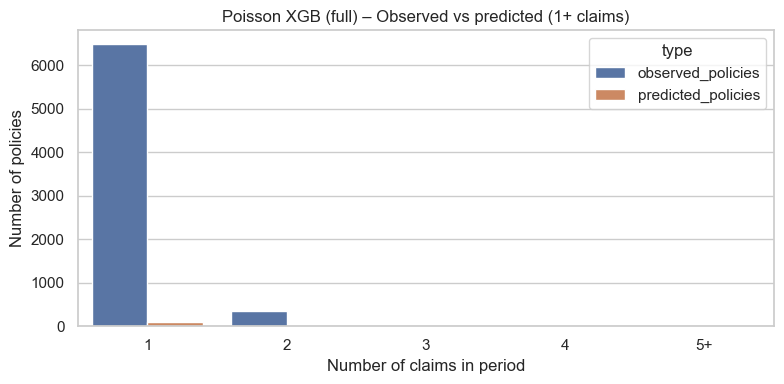

,n_claims,observed_policies,predicted_policies
0,1,6473,104
1,2,355,0
2,3,16,0
3,4,1,0
4,5,0,0
5,6,1,0
6,7,0,0
7,8,0,0
8,9,0,0
9,10,0,0


In [6]:
poisson_reg = XGBRegressor(**POISSON_XGB_PARAMS)

poisson_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", poisson_reg),
    ]
)

poisson_pipeline.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)

y_pred_poisson_test = poisson_pipeline.predict(X_test)
y_pred_poisson_test = np.clip(y_pred_poisson_test, 1e-9, None)

metrics_poisson, y_pred_poisson_round = evaluate_count_model(
    y_true=y_test.values,
    y_pred=y_pred_poisson_test,
    label="Poisson XGB (tuned, full features)",
)

plot_observed_vs_predicted_counts(
    y_true=y_test.values,
    y_pred_round=y_pred_poisson_round,
    max_count=5,
    title_prefix="Poisson XGB (full) – ",
)

positive_table_poisson = build_positive_count_table(
    y_true=y_test.values,
    y_pred_round=y_pred_poisson_round,
    max_count=15,
)
positive_table_poisson.head(10)

# Tuned Tweedie XGBoost model (optional alternative)

In [7]:
tweedie_reg = XGBRegressor(**TWEEDIE_XGB_PARAMS)

tweedie_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", tweedie_reg),
    ]
)

tweedie_pipeline.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)

y_pred_tweedie_test = tweedie_pipeline.predict(X_test)
y_pred_tweedie_test = np.clip(y_pred_tweedie_test, 1e-9, None)

metrics_tweedie, y_pred_tweedie_round = evaluate_count_model(
    y_true=y_test.values,
    y_pred=y_pred_tweedie_test,
    label="Tweedie XGB (tuned, full features)",
)


=== Tweedie XGB (tuned, full features) ===
Poisson deviance            : 0.3055
RMSE (claims)               : 0.2360
Exact match (rounded)       : 0.949
Zero share (true)           : 0.950
Zero share (pred)           : 1.000
Non-zero recall             : 0.001
Non-zero precision          : 0.242
KL divergence (0/1/2/3+)    : 0.2369


# Feature importance diagnostics (Poisson XGB)

In this section I inspect:
- raw XGBoost importances at the one-hot encoded level (top 20 features),
- aggregated importances at the original feature level
  (summing all dummies that belong to the same categorical variable).

This helps check that the model relies on business-reasonable drivers
such as BonusMalus, region, brand, age, etc.

Top 20 (one-hot level) feature importances:


,feature,importance
0,BonusMalus,0.097899
1,VehBrand_lumped_B12,0.094445
2,VehAge,0.035330
3,VehGas_Regular,0.034047
4,Region_lumped_R24,0.033042
5,DrivAge,0.032505
6,Region_lumped_R53,0.031862
7,Region_lumped_R91,0.031523
8,VehGas_Diesel,0.029174
9,VehPower,0.028625


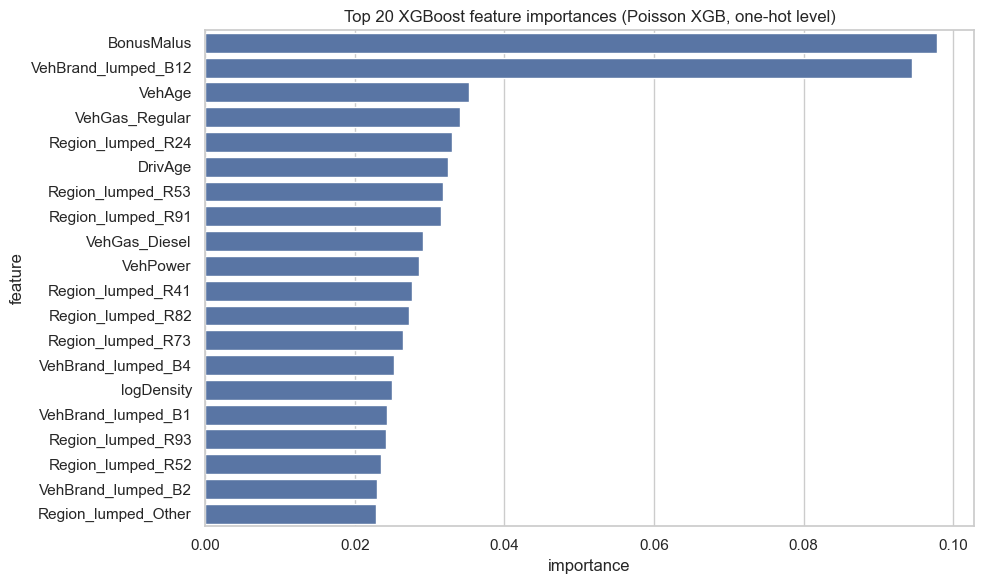


Bottom 20 (one-hot level) feature importances:


,feature,importance
33,Region_lumped_R54,0.019934
32,Area_D,0.020734
31,Area_A,0.020737
30,Area_B,0.021070
29,Region_lumped_R72,0.021263
28,Area_C,0.021332
27,VehBrand_lumped_B6,0.021344
26,Area_E,0.021431
25,VehBrand_lumped_Other,0.021932
24,Region_lumped_R31,0.022037


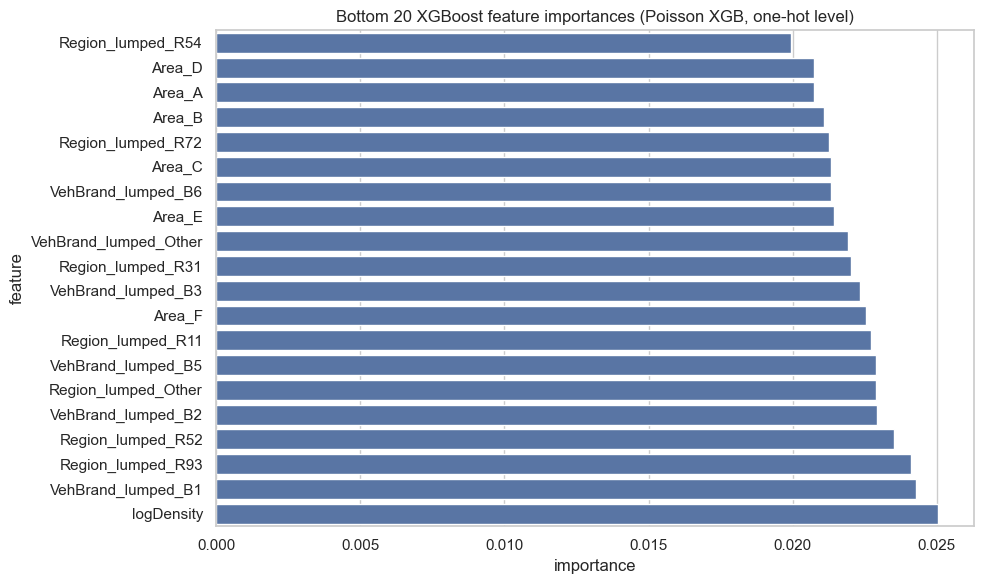


Aggregated feature importance by original feature:


,base_feature,importance
0,Region_lumped,0.334223
1,VehBrand_lumped,0.255310
2,Area,0.127849
3,BonusMalus,0.097899
4,VehGas,0.063221
5,VehAge,0.035330
6,DrivAge,0.032505
7,VehPower,0.028625
8,logDensity,0.025038


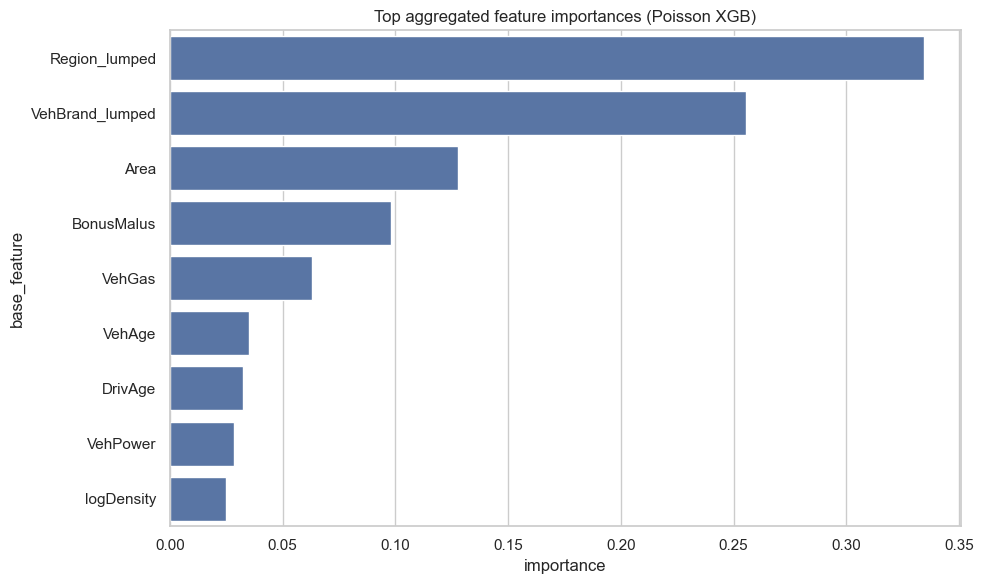


Aggregated feature importance by original feature (bottom 15):


,base_feature,importance
8,logDensity,0.025038
7,VehPower,0.028625
6,DrivAge,0.032505
5,VehAge,0.035330
4,VehGas,0.063221
3,BonusMalus,0.097899
2,Area,0.127849
1,VehBrand_lumped,0.255310
0,Region_lumped,0.334223


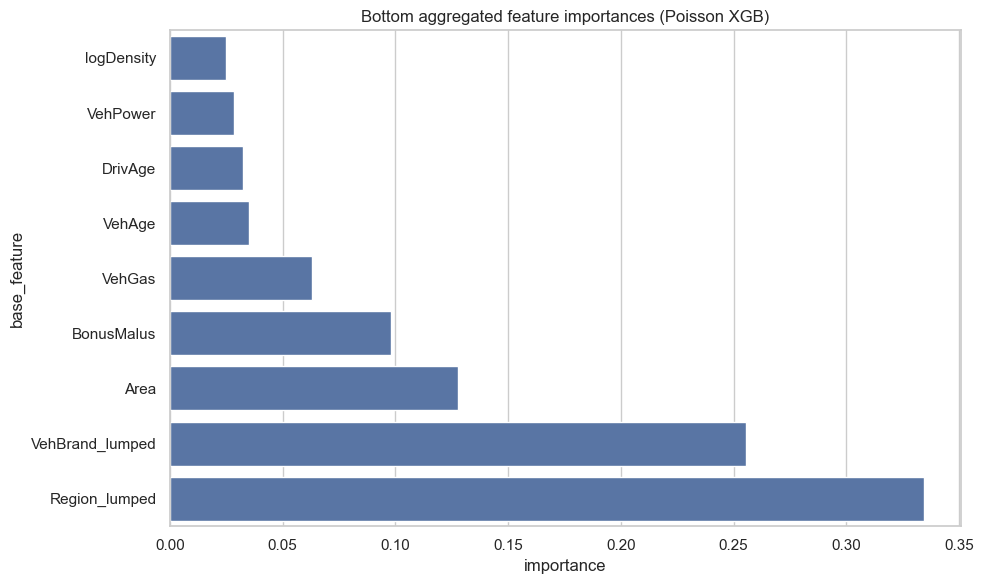

In [15]:
# Extract fitted preprocessing and model from the final Poisson pipeline
preprocess_final = poisson_pipeline.named_steps["preprocess"]
xgb_final = poisson_pipeline.named_steps["model"]

# Original numeric / categorical feature lists used in the ColumnTransformer
num_features_final = preprocess_final.transformers_[0][2]
cat_features_final = preprocess_final.transformers_[1][2]

# One-hot encoded column names for categorical features
ohe_final = preprocess_final.named_transformers_["cat"]
ohe_feature_names_final = ohe_final.get_feature_names_out(cat_features_final)

# Concatenate numeric and one-hot names to align with model.feature_importances_
all_feature_names_final = np.concatenate([num_features_final, ohe_feature_names_final])
importances_final = xgb_final.feature_importances_

fi_df_final = (
    pd.DataFrame(
        {"feature": all_feature_names_final, "importance": importances_final}
    )
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

print("Top 20 (one-hot level) feature importances:")
display(fi_df_final.head(20))

# --- Plot 1: raw top-20 importances (this is the one from your original experiments) ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fi_df_final.head(20),
    x="importance",
    y="feature",
)
plt.title("Top 20 XGBoost feature importances (Poisson XGB, one-hot level)")
plt.tight_layout()
plt.show()

# --- Plot 2: raw bottom-20 importances ---
bottom20 = fi_df_final.tail(20).sort_values("importance", ascending=True)

print("\nBottom 20 (one-hot level) feature importances:")
display(bottom20)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=bottom20,
    x="importance",
    y="feature",
)
plt.title("Bottom 20 XGBoost feature importances (Poisson XGB, one-hot level)")
plt.tight_layout()
plt.show()
# --- Aggregated importances by original feature (summing one-hot dummies) ---
agg_importance = aggregate_importance_by_source(
    fi_df=fi_df_final,
    cat_cols=list(cat_features_final),
)

print("\nAggregated feature importance by original feature:")
display(agg_importance.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(
    data=agg_importance.head(15),
    x="importance",
    y="base_feature",
)
plt.title("Top aggregated feature importances (Poisson XGB)")
plt.tight_layout()
plt.show()

# --- Bottom aggregated importances (least important original features) ---
agg_bottom = agg_importance.sort_values("importance", ascending=True).head(15)

print("\nAggregated feature importance by original feature (bottom 15):")
display(agg_bottom)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=agg_bottom,
    x="importance",
    y="base_feature",
)
plt.title("Bottom aggregated feature importances (Poisson XGB)")
plt.tight_layout()
plt.show()

# Feature ablation experiments

Goal:
- Check whether we can drop low-importance or redundant features
  without hurting Poisson deviance on the test set.

We reuse the tuned Poisson hyperparameters and only change the feature set.

In [21]:
base_features = XGB_FEATURE_COLS

ablation_experiments = {
    "full": base_features,
    "no_area": [f for f in base_features if f != "Area"],
    "no_logdensity": [f for f in base_features if f != "logDensity"],
    "no_area_logdensity": [
        f for f in base_features if f not in ["Area", "logDensity"]
    ],
    "no_age_power": [f for f in base_features if f not in ["VehAge", "VehPower"]],
}

ablation_results = []

for name, feats in ablation_experiments.items():
    print(f"\n=== Ablation experiment: {name} ===")
    print("Features:", feats)

    # Restrict train/test to selected features
    X_train_exp = X_train[feats]
    X_test_exp = X_test[feats]

    # Rebuild preprocessing for this subset
    cat_feats_exp = X_train_exp.select_dtypes(include=["object", "category"]).columns.tolist()
    num_feats_exp = X_train_exp.select_dtypes(include=["int64", "float64"]).columns.tolist()

    preprocess_exp = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_feats_exp),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats_exp),
        ]
    )

    xgb_reg_exp = XGBRegressor(**POISSON_XGB_PARAMS)

    xgb_pipe_exp = Pipeline(
        steps=[
            ("preprocess", preprocess_exp),
            ("model", xgb_reg_exp),
        ]
    )

    xgb_pipe_exp.fit(
        X_train_exp,
        y_train,
        model__sample_weight=exp_train,
    )

    y_pred_exp = xgb_pipe_exp.predict(X_test_exp)
    y_pred_exp = np.clip(y_pred_exp, 1e-9, None)

    dev = mean_poisson_deviance(y_test, y_pred_exp)
    rmse = root_mean_squared_error(y_test, y_pred_exp)

    print(f"Poisson deviance: {dev:.4f}, RMSE: {rmse:.4f}")
    ablation_results.append((name, dev, rmse))

ablation_df = (
    pd.DataFrame(
        ablation_results,
        columns=["experiment", "poisson_dev", "rmse"],
    )
    .sort_values("poisson_dev")
    .reset_index(drop=True)
)

ablation_df


=== Ablation experiment: full ===
Features: ['Area', 'VehBrand_lumped', 'VehGas', 'Region_lumped', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'logDensity']
Poisson deviance: 0.3057, RMSE: 0.2360

=== Ablation experiment: no_area ===
Features: ['VehBrand_lumped', 'VehGas', 'Region_lumped', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'logDensity']
Poisson deviance: 0.3056, RMSE: 0.2360

=== Ablation experiment: no_logdensity ===
Features: ['Area', 'VehBrand_lumped', 'VehGas', 'Region_lumped', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus']
Poisson deviance: 0.3061, RMSE: 0.2361

=== Ablation experiment: no_area_logdensity ===
Features: ['VehBrand_lumped', 'VehGas', 'Region_lumped', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus']
Poisson deviance: 0.3063, RMSE: 0.2362

=== Ablation experiment: no_age_power ===
Features: ['Area', 'VehBrand_lumped', 'VehGas', 'Region_lumped', 'DrivAge', 'BonusMalus', 'logDensity']
Poisson deviance: 0.3132, RMSE: 0.2375


,experiment,poisson_dev,rmse
0,no_area,0.305607,0.235982
1,full,0.305655,0.235991
2,no_logdensity,0.306051,0.236107
3,no_area_logdensity,0.306321,0.236158
4,no_age_power,0.313174,0.237505


# Final Poisson XGB model **without `Area`**


=== Poisson XGB (tuned, without Area) ===
Poisson deviance            : 0.3056
RMSE (claims)               : 0.2360
Exact match (rounded)       : 0.949
Zero share (true)           : 0.950
Zero share (pred)           : 0.999
Non-zero recall             : 0.005
Non-zero precision          : 0.354
KL divergence (0/1/2/3+)    : 0.1864

Comparison of Poisson models (with vs without Area) – Poisson deviance:
  With Area   : 0.305655
  Without Area: 0.305607


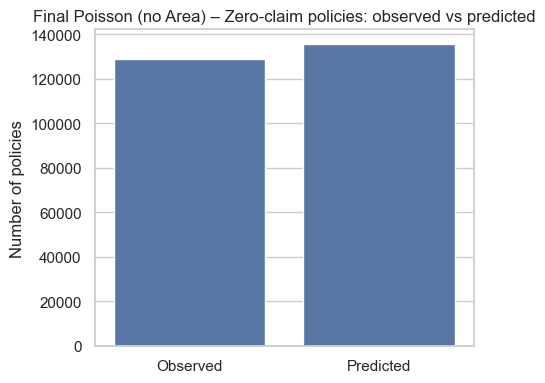

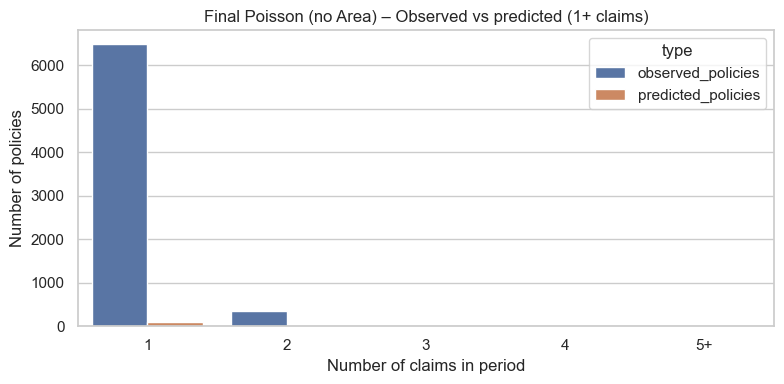

,n_claims,observed_policies,predicted_policies
0,1,6473,96
1,2,355,0
2,3,16,0
3,4,1,0
4,5,0,0
5,6,1,0
6,7,0,0
7,8,0,0
8,9,0,0
9,10,0,0


In [10]:
final_features = [f for f in XGB_FEATURE_COLS if f != "Area"]

X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

cat_feats_final_no_area = (
    X_train_final.select_dtypes(include=["object", "category"]).columns.tolist()
)
num_feats_final_no_area = (
    X_train_final.select_dtypes(include=["int64", "float64"]).columns.tolist()
)

preprocess_final_no_area = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_feats_final_no_area),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats_final_no_area),
    ]
)

poisson_reg_no_area = XGBRegressor(**POISSON_XGB_PARAMS)

poisson_pipeline_no_area = Pipeline(
    steps=[
        ("preprocess", preprocess_final_no_area),
        ("model", poisson_reg_no_area),
    ]
)

poisson_pipeline_no_area.fit(
    X_train_final,
    y_train,
    model__sample_weight=exp_train,
)

y_pred_poisson_no_area = poisson_pipeline_no_area.predict(X_test_final)
y_pred_poisson_no_area = np.clip(y_pred_poisson_no_area, 1e-9, None)

metrics_no_area, y_pred_no_area_round = evaluate_count_model(
    y_true=y_test.values,
    y_pred=y_pred_poisson_no_area,
    label="Poisson XGB (tuned, without Area)",
)

print(
    "\nComparison of Poisson models (with vs without Area) – Poisson deviance:"
)
print(f"  With Area   : {metrics_poisson['poisson_deviance']:.6f}")
print(f"  Without Area: {metrics_no_area['poisson_deviance']:.6f}")

plot_observed_vs_predicted_counts(
    y_true=y_test.values,
    y_pred_round=y_pred_no_area_round,
    max_count=5,
    title_prefix="Final Poisson (no Area) – ",
)

positive_table_final = build_positive_count_table(
    y_true=y_test.values,
    y_pred_round=y_pred_no_area_round,
    max_count=15,
)
positive_table_final.head(10)

# Diagnostics: top absolute errors for the final model (no Area)

In [11]:
diagnostics_df = X_test_final.copy()
diagnostics_df["ClaimNb"] = y_test
diagnostics_df["Exposure"] = exp_test
diagnostics_df["pred_final"] = y_pred_poisson_no_area
diagnostics_df["residual"] = diagnostics_df["ClaimNb"] - diagnostics_df["pred_final"]
diagnostics_df["abs_residual"] = diagnostics_df["residual"].abs()

# If these band columns exist in df, bring them in for context:
segment_cols = [
    "BonusMalusBand",
    "DrivAgeBand",
    "VehAgeBand",
    "Area",
    "Region_lumped",
    "VehGas",
]

for col in segment_cols:
    if col in df.columns:
        diagnostics_df[col] = df.loc[diagnostics_df.index, col]

top10_errors_final = diagnostics_df.sort_values("abs_residual", ascending=False).head(10)
top10_errors_final

,VehBrand_lumped,VehGas,Region_lumped,VehPower,VehAge,DrivAge,BonusMalus,logDensity,ClaimNb,Exposure,pred_final,residual,abs_residual,BonusMalusBand,DrivAgeBand,VehAgeBand,Area
304484,B1,Regular,R91,4,12,52,50,6.715383,6,0.33,0.786588,5.213412,5.213412,50-59,45-59,8-15,D
364437,B3,Diesel,R11,5,9,23,90,8.842893,4,0.27,0.083612,3.916388,3.916388,80-99,18-24,8-15,E
535261,B2,Diesel,R31,5,15,62,60,8.037866,3,0.77,0.034014,2.965986,2.965986,60-79,60+,8-15,E
185528,B1,Regular,R93,5,6,35,57,8.107117,3,0.97,0.053075,2.946925,2.946925,50-59,30-44,3-7,E
7154,B1,Regular,R24,6,0,41,50,5.602119,3,0.65,0.053916,2.946084,2.946084,50-59,30-44,0-2,C
630041,B2,Diesel,Other,6,7,52,50,6.470800,3,0.91,0.061108,2.938892,2.938892,50-59,45-59,3-7,D
4808,B12,Regular,R11,4,1,28,100,8.113726,3,0.09,0.061543,2.938457,2.938457,100-129,25-29,0-2,E
214606,B1,Regular,Other,4,10,24,90,7.578657,3,0.32,0.061730,2.938270,2.938270,80-99,18-24,8-15,D
497569,B12,Diesel,R11,8,2,53,52,9.663071,3,0.21,0.065943,2.934057,2.934057,50-59,45-59,0-2,F
41661,B3,Diesel,Other,5,1,37,61,5.365976,3,1.00,0.075227,2.924773,2.924773,60-79,30-44,0-2,C


# Hyperparameter optimisation (for reference only)

Here we document the RandomizedSearchCV stages that produced the frozen
`POISSON_XGB_PARAMS` and `TWEEDIE_XGB_PARAMS` used above.

> **Important:** These cells are documentation only in the production notebook.
> Whole process with training and hyperparameter optimisation is available in xgb_experiments notebook file
> The actual searches are not re-run to keep training time reasonable.

All searches used:

- Poisson deviance as the scoring function:

  ```python
  from sklearn.metrics import make_scorer, mean_poisson_deviance

  poisson_scorer = make_scorer(
      mean_poisson_deviance,
      greater_is_better=False,
  )
  ```

- Exposure as sample_weight:

  ```python
  xgb_search.fit(
      X_train,
      y_train,
      model__sample_weight=exp_train,
  )
  ```

- A preprocessing pipeline with numeric passthrough + OneHotEncoder for categoricals:

  ```python
  from sklearn.compose import ColumnTransformer
  from sklearn.preprocessing import OneHotEncoder
  from sklearn.pipeline import Pipeline

  preprocess = ColumnTransformer(
      transformers=[
          ("num", "passthrough", num_features),
          ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
      ]
  )
  ```

The final, frozen hyperparameters you see in the main notebook came from the
**last (ultra-fine) Poisson search** and a separate **Tweedie search**.

---

### 1. Baseline Poisson XGB search (coarse grid)

First, a simple Poisson XGBoost with a coarse grid to get into the right ballpark:

```python
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

xgb_reg = XGBRegressor(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
)

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_reg),
])

param_distributions = {
    "model__n_estimators": [200, 400, 600, 800],
    "model__max_depth": [3, 4, 5, 6],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__min_child_weight": [1, 5, 10],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=poisson_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

xgb_search.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)
```

**Result (coarse Poisson search):**

- Best params:
  ```python
  {
      "model__subsample": 0.7,
      "model__n_estimators": 400,
      "model__min_child_weight": 5,
      "model__max_depth": 6,
      "model__learning_rate": 0.05,
      "model__colsample_bytree": 1.0,
  }
  ```
- Best CV Poisson deviance: `~ -0.305107`

This configuration was used as a starting point for the more detailed Poisson search.

---

### 2. Main Poisson XGB search (wider / deeper grid, with regularisation)

Next, a richer search including L1/L2 regularisation, gamma and a wider grid.
StratifiedKFold was used to respect the strong zero inflation:

```python
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

has_claim = (y_train > 0).astype(int)

skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

xgb_reg = XGBRegressor(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
)

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_reg),
])

param_distributions = {
    "model__n_estimators":      [300, 500, 700, 900, 1100],
    "model__max_depth":         [3, 4, 5, 6, 7],
    "model__learning_rate":     [0.02, 0.03, 0.05, 0.07, 0.1],
    "model__subsample":         [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":  [0.6, 0.75, 0.9, 1.0],
    "model__min_child_weight":  [1, 3, 5, 10],
    "model__gamma":             [0.0, 0.1, 0.3, 1.0],
    "model__reg_lambda":        [0.0, 1.0, 5.0, 10.0, 20.0],
    "model__reg_alpha":         [0.0, 0.1, 0.5, 1.0, 2.0],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    scoring=poisson_scorer,
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=42,
)

xgb_search.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)
```

**Result (main Poisson search):**

- Best params:
  ```python
  {
      "model__subsample": 0.8,
      "model__reg_lambda": 1.0,
      "model__reg_alpha": 1.0,
      "model__n_estimators": 900,
      "model__min_child_weight": 5,
      "model__max_depth": 7,
      "model__learning_rate": 0.05,
      "model__gamma": 0.3,
      "model__colsample_bytree": 0.75,
  }
  ```
- Best CV Poisson deviance: `~ -0.304363`

A `UserWarning` appeared about the least populated class having only 1 member
for some folds (because of very rare high claim counts). This does not affect
the final frozen parameters; in the production notebook warnings are suppressed.

---

### 3. Fine Poisson XGB search (narrowed around main region)

After the main search, a *fine* search was run around the promising region:

```python
fine_param_distributions = {
    "model__n_estimators":     [300, 500, 700],
    "model__max_depth":        [6, 7, 8],
    "model__learning_rate":    [0.035, 0.05, 0.065],
    "model__subsample":        [0.9, 1.0],
    "model__colsample_bytree": [0.65, 0.75, 0.85],
    "model__min_child_weight": [1, 3],
    "model__gamma":            [0.0, 0.1, 0.2],
    "model__reg_lambda":       [0.5, 1.0, 2.0],
    "model__reg_alpha":        [0.5, 1.0, 2.0],
}

xgb_search_fine = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=fine_param_distributions,
    n_iter=25,
    scoring=poisson_scorer,
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=123,
)

xgb_search_fine.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)
```

**Result (fine Poisson search):**

- Best params (fine):
  ```python
  {
      "model__subsample": 0.9,
      "model__reg_lambda": 1.0,
      "model__reg_alpha": 2.0,
      "model__n_estimators": 500,
      "model__min_child_weight": 3,
      "model__max_depth": 8,
      "model__learning_rate": 0.065,
      "model__gamma": 0.2,
      "model__colsample_bytree": 0.65,
  }
  ```
- Best CV Poisson deviance (fine): `~ -0.304014`

Again, the same warning about rare classes in some folds was observed.

---

### 4. Ultra-fine Poisson XGB search (final Poisson config)

Finally, an ultra-fine Poisson XGB search was run around the best fine settings.
This search produced the **frozen Poisson hyperparameters** used in the main notebook:

```python
ultra_fine_param_distributions = {
    "model__n_estimators":     [400, 500, 600],
    "model__max_depth":        [7, 8, 9],
    "model__learning_rate":    [0.05, 0.06, 0.07],
    "model__subsample":        [0.85, 0.9, 0.95],
    "model__colsample_bytree": [0.6, 0.65, 0.7],
    "model__min_child_weight": [2, 3, 4],
    "model__gamma":            [0.1, 0.2, 0.3],
    "model__reg_lambda":       [0.5, 1.0, 1.5],
    "model__reg_alpha":        [1.0, 2.0, 3.0],
}

xgb_search_ultra = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=ultra_fine_param_distributions,
    n_iter=20,
    scoring=poisson_scorer,
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=321,
)

xgb_search_ultra.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)
```

**Result (ultra Poisson search):**

- Best params (ultra):
  ```python
  {
      "model__subsample": 0.95,
      "model__reg_lambda": 0.5,
      "model__reg_alpha": 1.0,
      "model__n_estimators": 600,
      "model__min_child_weight": 2,
      "model__max_depth": 9,
      "model__learning_rate": 0.05,
      "model__gamma": 0.3,
      "model__colsample_bytree": 0.65,
  }
  ```
- Best CV Poisson deviance (ultra): `~ -0.303756`

These are exactly the values hard-coded in:

```python
POISSON_XGB_PARAMS = dict(
    objective="count:poisson",
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
    n_estimators=600,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.95,
    colsample_bytree=0.65,
    min_child_weight=2,
    gamma=0.3,
    reg_lambda=0.5,
    reg_alpha=1.0,
    n_jobs=-1,
    verbosity=0,
)
```

---

### 5. Tweedie XGB search

In parallel to the Poisson XGB, a Tweedie XGB was also tuned to allow for
over-dispersion and slightly different variance structure. The Poisson deviance
remained the evaluation metric to keep results comparable.

```python
xgb_tweedie = XGBRegressor(
    objective="reg:tweedie",
    tweedie_variance_power=1.2,  # initial guess
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
)

xgb_tweedie_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_tweedie),
])

param_distributions_tweedie = {
    "model__tweedie_variance_power": [1.0, 1.1, 1.2, 1.3, 1.5],
    "model__n_estimators":      [300, 500, 700],
    "model__max_depth":         [4, 5, 6],
    "model__learning_rate":     [0.03, 0.05, 0.07],
    "model__subsample":         [0.8, 0.9, 1.0],
    "model__colsample_bytree":  [0.7, 0.85, 1.0],
    "model__min_child_weight":  [1, 3, 5],
    "model__gamma":             [0.0, 0.1, 0.3],
    "model__reg_lambda":        [1.0, 5.0, 10.0],
    "model__reg_alpha":         [0.0, 0.5, 1.0],
}

xgb_tweedie_search = RandomizedSearchCV(
    estimator=xgb_tweedie_pipe,
    param_distributions=param_distributions_tweedie,
    n_iter=40,
    scoring=poisson_scorer,
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=123,
)

xgb_tweedie_search.fit(
    X_train,
    y_train,
    model__sample_weight=exp_train,
)
```

**Result (Tweedie XGB search):**

- Best Tweedie-XGB params:
  ```python
  {
      "model__tweedie_variance_power": 1.3,
      "model__subsample": 0.8,
      "model__reg_lambda": 10.0,
      "model__reg_alpha": 0.0,
      "model__n_estimators": 500,
      "model__min_child_weight": 3,
      "model__max_depth": 6,
      "model__learning_rate": 0.05,
      "model__gamma": 0.0,
      "model__colsample_bytree": 0.7,
  }
  ```
- Best Tweedie-XGB CV Poisson deviance: `~ -0.303946`

These values are frozen in:

```python
TWEEDIE_XGB_PARAMS = dict(
    objective="reg:tweedie",
    tweedie_variance_power=1.3,
    tree_method="hist",
    device="cuda",
    eval_metric="poisson-nloglik",
    random_state=42,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=0.0,
    reg_lambda=10.0,
    reg_alpha=0.0,
    n_jobs=-1,
    verbosity=0,
)
```

In the main notebook, both the Poisson and Tweedie configurations are treated
as **fixed, production-ready hyperparameter sets**, and only the final models
are fitted on the current train/test split.
